# Import dependencies

In [4]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml

from pathlib import Path

import pyvista as pv
pv.set_jupyter_backend("static")
pv.global_theme.color = "black"

device = torch.device("cpu")

# Approximating with quantum circuits

In [46]:
n_qubits = 1
dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(inputs, weights):
    qml.Rot(weights[0, 0], weights[0, 1], weights[0, 2],
            wires=range(n_qubits))
    qml.RX(inputs[0], wires=range(n_qubits))
    qml.Rot(weights[1, 0], weights[1, 1], weights[1, 2],
            wires=range(n_qubits))
    qml.RX(inputs[0], wires=range(n_qubits))
    qml.Rot(weights[1, 0], weights[1, 1], weights[1, 2],
            wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (2, 3)}

In [107]:
n_qubits = 4
n_layers = 1
n_depth = 1

dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(inputs, weights):
    
    qml.BasicEntanglerLayers(weights[0], wires=range(n_qubits))
    for i in range(n_qubits):
        qml.RX(inputs[0], wires=i)
    qml.BasicEntanglerLayers(weights[0], wires=range(n_qubits))
    
    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_depth, n_layers, n_qubits)}

In [146]:
n_qubits = 4
n_layers = 1
n_depth = 1 + 1

dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(inputs, weights):
    
    qml.StronglyEntanglingLayers(weights[0], wires=range(n_qubits))
    for i in range(n_qubits):
        qml.RX(inputs[0], wires=i)
    qml.StronglyEntanglingLayers(weights[1], wires=range(n_qubits))
    
    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_depth, n_layers, n_qubits, 3)}

In [147]:
print(qml.draw(circuit, expansion_strategy="device")(inputs=torch.ones(1), weights=torch.rand(weight_shapes["weights"])))

0: ──Rot(0.39,0.68,0.20)─╭●───────╭X──RX(1.00)──Rot(0.81,0.27,0.76)─╭●───────╭X─┤  <Z>
1: ──Rot(0.48,0.78,0.47)─╰X─╭●────│───RX(1.00)──Rot(0.98,0.17,0.75)─╰X─╭●────│──┤     
2: ──Rot(0.82,0.44,0.57)────╰X─╭●─│───RX(1.00)──Rot(0.33,0.84,0.20)────╰X─╭●─│──┤     
3: ──Rot(0.68,0.12,0.27)───────╰X─╰●──RX(1.00)──Rot(0.74,0.88,0.97)───────╰X─╰●─┤     


In [148]:
w = 2

In [119]:
f = lambda x: 0.8*torch.sin(w*x)

In [149]:
f = lambda x: 0.1 + 0.3*torch.cos(w*x) - 0.3*torch.sin(w*x)

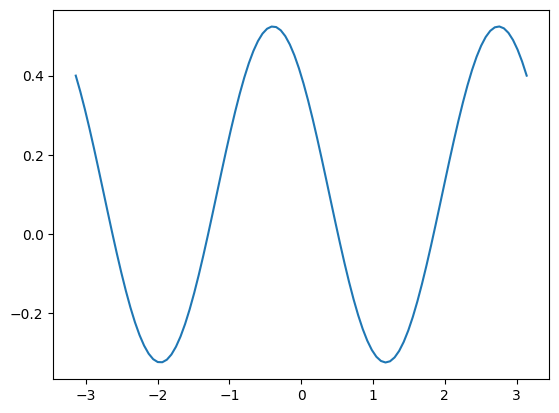

In [150]:
x = torch.linspace(-torch.pi, torch.pi, 100)
plt.plot(x, f(x))

In [151]:
class FreqNet(torch.nn.Module):
    def __init__(self, circuit, weight_shapes):
        super().__init__()
        self.enc = torch.nn.Linear(1, 1, bias=False)
        self.qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)
        self.dec = torch.nn.Linear(1, 1, bias=False)
        
    def forward(self, x):
        # x = w * x
        x = self.enc(x)
        x = self.qlayer(x).view(-1, 1)
        x = self.dec(x)
        
        return x

In [152]:
net = FreqNet(circuit, weight_shapes)

In [153]:
def plot(qlayer, f):
    x = torch.linspace(-torch.pi, torch.pi, 100)
    y_exact = f(x)
    with torch.no_grad():
        y_pred = qlayer(x.view(-1, 1)).flatten()
    
    plt.figure()
    plt.plot(x, y_exact, label="exact")
    plt.plot(x, y_pred, label="pred")
    
    plt.legend()
    plt.show()

def fit(qlayer, f, epochs=100):

    criterion = torch.nn.MSELoss()
    optim = torch.optim.Adam(qlayer.parameters(), lr=0.01)
    
    x = torch.linspace(-torch.pi, torch.pi, 100)
    y_exact = f(x)
    
    for e in range(epochs):
        y_pred = qlayer(x.view(-1, 1)).flatten()
        loss = criterion(y_pred, y_exact)
        if e % 10 == 0:
            print(f"epoch: {e}, loss: {loss}")
        
        optim.zero_grad()
        loss.backward()
        optim.step()

In [154]:
fit(net, f)

/home/lurker/miniconda3/envs/torch_dde_q/lib/python3.9/site-packages/pennylane/tape/qscript.py:569: UserWarning: The get_operation will soon be updated to also return the index of the trainable operation in the tape. If you want to switch to the new behavior, you can pass `return_op_index=True`
  warnings.warn(


epoch: 0, loss: 0.0941549688577652
epoch: 10, loss: 0.08150321245193481
epoch: 20, loss: 0.06731054931879044
epoch: 30, loss: 0.046381983906030655
epoch: 40, loss: 0.02019919827580452
epoch: 50, loss: 0.002807339420542121
epoch: 60, loss: 0.0003808609035331756
epoch: 70, loss: 0.0007807206129655242
epoch: 80, loss: 0.00014460048987530172
epoch: 90, loss: 2.1552717953454703e-05


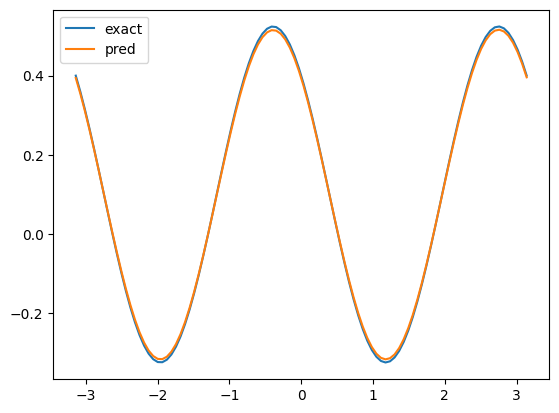

In [155]:
plot(net, f)

In [145]:
net._modules["dec"].weight

Parameter containing:
tensor([[-2.3395]], requires_grad=True)